# Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
import matplotlib.axes as axs

# Data Preparation

In [2]:
df_purchase = pd.read_csv("purchase data.csv")

scaler = pickle.load(open('C:/my files/programming/data science/customer analytics/segmentation/scaler.pickle', 'rb'))

pca = pickle.load(open('C:/my files/programming/data science/customer analytics/segmentation/pca.pickle', 'rb'))

kmeans_pca = pickle.load(open('C:/my files/programming/data science/customer analytics/segmentation/kmeans_pca.pickle', 'rb'))

In [3]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
# transforming the new feature data 
df_purchase_segm_std = scaler.transform(features)

# using PCA model from before
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca

segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

# Purchase Probability Model

In [4]:
Y = df_pa['Incidence']

In [5]:
X = pd.DataFrame()
X['Mean Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'])/ 5

In [6]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X,Y)

LogisticRegression(solver='sag')

In [7]:
model_purchase.coef_

array([[-2.34848836]])

# Price Elasticity of Purchase Probability

In [8]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [111]:
price_range = np.arange(0.5, 3.5, 0.01)

In [112]:
df_price_range = pd.DataFrame(price_range)

In [113]:
# getting probability from LogisticRegression
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:,1]

In [114]:
# Price Elasticity
pe = model_purchase.coef_[:,0] * price_range * (1 - purchase_pr)

In [115]:
df_price_elasticities = pd.DataFrame(price_range)

In [116]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: 'Price_Point'})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities.head(15)

,Price_Point,Mean_PE
0,0.50,-0.096494
1,0.51,-0.100566
2,0.52,-0.104765
3,0.53,-0.109095
4,0.54,-0.113558
5,0.55,-0.118158
6,0.56,-0.122898
7,0.57,-0.127782
8,0.58,-0.132812
9,0.59,-0.137992


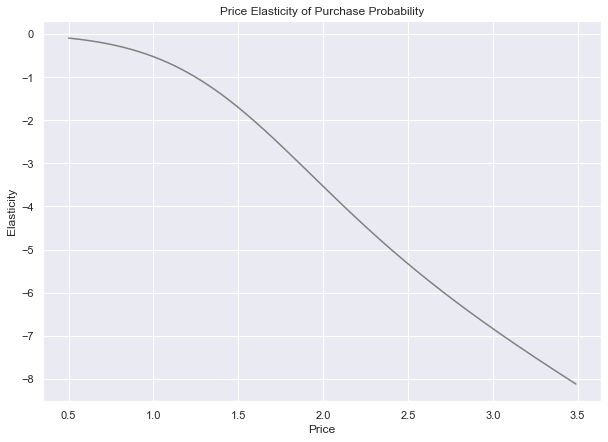

In [16]:
plt.figure(figsize=(10,7))
plt.plot(price_range,pe,color='grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

# Purchase Probability by Segments

## Segment 1 - Well Off

In [17]:
df_pa['Segment'].unique()

array([3, 1, 2, 0])

In [18]:
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [19]:
Y = df_pa_segment_1['Incidence']

In [20]:
X = pd.DataFrame()

In [21]:
X['Mean Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5'])/5

In [22]:
model_incidence_segment_1 = LogisticRegression(solver= 'sag')
model_incidence_segment_1.fit(X,Y)

LogisticRegression(solver='sag')

In [23]:
model_incidence_segment_1.coef_

array([[-1.24480785]])

In [24]:
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:,1]
pe_segment_1 = model_incidence_segment_1.coef_[:,0] * price_range * (1 - purchase_pr_segment_1)

### Result

In [26]:
df_price_elasticities['PE_segment_1'] = pe_segment_1
df_price_elasticities.head(10)

,Price_Point,Mean_PE,PE_segment_1
0,0.50,-0.096494,-0.167862
1,0.51,-0.100566,-0.172780
2,0.52,-0.104765,-0.177769
3,0.53,-0.109095,-0.182828
4,0.54,-0.113558,-0.187958
5,0.55,-0.118158,-0.193160
6,0.56,-0.122898,-0.198435
7,0.57,-0.127782,-0.203781
8,0.58,-0.132812,-0.209201
9,0.59,-0.137992,-0.214695


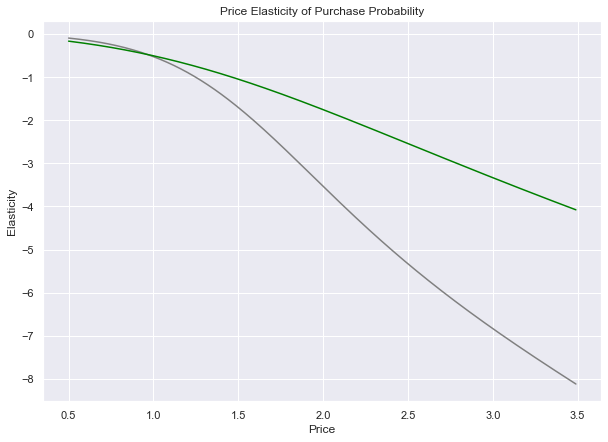

In [27]:
plt.figure(figsize=(10,7))
plt.plot(price_range,pe,color='grey')
plt.plot(price_range,pe_segment_1,color='green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

## Segment 2 - Career focused

In [28]:
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]
Y = df_pa_segment_2['Incidence']
X = pd.DataFrame()

X['Mean Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5'])/5

model_incidence_segment_2 = LogisticRegression(solver= 'sag')
model_incidence_segment_2.fit(X,Y)

Y_segment_2 = model_incidence_segment_2.predict_proba(df_price_range)
purchase_pr_segment_2 = Y_segment_2[:,1]
pe_segment_2 = model_incidence_segment_2.coef_[:,0] * price_range * (1 - purchase_pr_segment_2)

### Results

In [30]:
df_price_elasticities['PE_segment_2'] = pe_segment_2
df_price_elasticities.head(10)

,Price_Point,Mean_PE,PE_segment_1,PE_segment_2
0,0.50,-0.096494,-0.167862,-0.117467
1,0.51,-0.100566,-0.172780,-0.121526
2,0.52,-0.104765,-0.177769,-0.125672
3,0.53,-0.109095,-0.182828,-0.129907
4,0.54,-0.113558,-0.187958,-0.134232
5,0.55,-0.118158,-0.193160,-0.138649
6,0.56,-0.122898,-0.198435,-0.143159
7,0.57,-0.127782,-0.203781,-0.147764
8,0.58,-0.132812,-0.209201,-0.152463
9,0.59,-0.137992,-0.214695,-0.157260


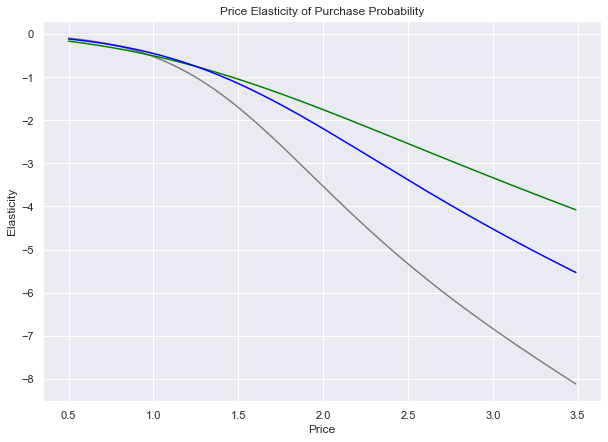

In [31]:
plt.figure(figsize=(10,7))
plt.plot(price_range,pe,color='grey')
plt.plot(price_range,pe_segment_1,color='green')
plt.plot(price_range,pe_segment_2,color='blue')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

## Segment 3 - fewer opp

In [32]:
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
Y = df_pa_segment_3['Incidence']
X = pd.DataFrame()

X['Mean Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5'])/5

model_incidence_segment_3 = LogisticRegression(solver= 'sag')
model_incidence_segment_3.fit(X,Y)

Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:,1]
pe_segment_3 = model_incidence_segment_3.coef_[:,0] * price_range * (1 - purchase_pr_segment_3)

### Results

In [33]:
df_price_elasticities['PE_segment_2'] = pe_segment_2
# df_price_elasticities

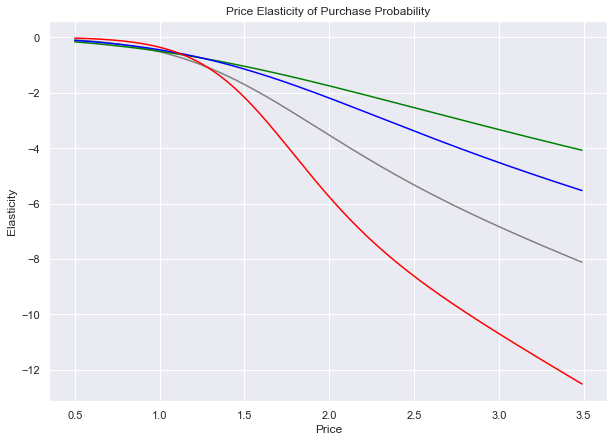

In [34]:
plt.figure(figsize=(10,7))
plt.plot(price_range,pe,color='grey')
plt.plot(price_range,pe_segment_1,color='green')
plt.plot(price_range,pe_segment_2,color='blue')
plt.plot(price_range,pe_segment_3,color='red')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()
# This segment is more inelastic than others in lower prices 

## Segment 4 - Standard

In [35]:
df_pa_segment_4 = df_pa[df_pa['Segment'] == 0]
Y = df_pa_segment_4['Incidence']
X = pd.DataFrame()

X['Mean Price'] = (df_pa_segment_4['Price_1'] + 
                   df_pa_segment_4['Price_2'] + 
                   df_pa_segment_4['Price_3'] + 
                   df_pa_segment_4['Price_4'] + 
                   df_pa_segment_4['Price_5'])/5

model_incidence_segment_4 = LogisticRegression(solver= 'sag')
model_incidence_segment_4.fit(X,Y)

Y_segment_4 = model_incidence_segment_4.predict_proba(df_price_range)
purchase_pr_segment_4 = Y_segment_4[:,1]
pe_segment_4 = model_incidence_segment_4.coef_[:,0] * price_range * (1 - purchase_pr_segment_4)

### Results

In [36]:
df_price_elasticities['PE_segment_4'] = pe_segment_4

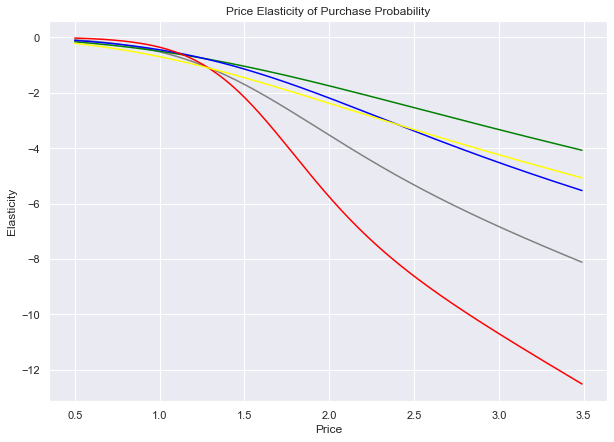

In [37]:
plt.figure(figsize=(10,7))
plt.plot(price_range,pe,color='grey')
plt.plot(price_range,pe_segment_1,color='green')
plt.plot(price_range,pe_segment_2,color='blue')
plt.plot(price_range,pe_segment_3,color='red')
plt.plot(price_range,pe_segment_4,color='yellow')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

# Purchase Probability by Promotion

## Data Preparation

In [38]:
Y = df_pa['Incidence']
X = pd.DataFrame()

X['Mean Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5'])/5

X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'])/5

## Model Estimation

In [39]:
model_incidense_promotion = LogisticRegression(solver='sag')
model_incidense_promotion.fit(X,Y)
model_incidense_promotion.coef_

array([[-1.49407357,  0.56152406]])

## Price Elasticity with Promotion

In [40]:
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_range"})

In [41]:
df_price_elasticity_promotion['Promotion'] = 1

In [42]:
Y_promotion = model_incidense_promotion.predict_proba(df_price_elasticity_promotion)

In [43]:
promo = Y_promotion[:,1]
price_elasticity_promo = model_incidense_promotion.coef_[:,0] * price_range * (1 - promo)

In [44]:
df_price_elasticities['Elascticity_Promotion'] = price_elasticity_promo

In [46]:
df_price_elasticity_promotion.head(5)

,Price_range,Promotion
0,0.50,1
1,0.51,1
2,0.52,1
3,0.53,1
4,0.54,1


## Price Elasticity with no Promotion

In [47]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_range"})

In [48]:
df_price_elasticity_promotion_no['Promotion'] = 0

In [49]:
Y_promotion_no = model_incidense_promotion.predict_proba(df_price_elasticity_promotion_no)

In [50]:
promo_no = Y_promotion_no[:,1]
price_elasticity_promo_no = model_incidense_promotion.coef_[:,0] * price_range * (1 - promo_no)

In [51]:
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_promo_no

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

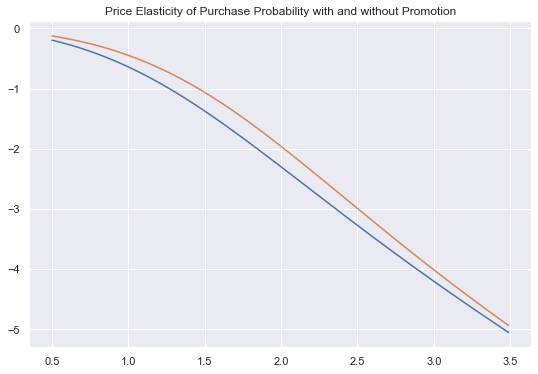

In [52]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_promo_no)
plt.plot(price_range, price_elasticity_promo)
plt.title('Price Elasticity of Purchase Probability with and without Promotion')

# Brand Choice

## Data Prep

In [53]:
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [55]:
pd.options.display.max_rows = 100
brand_choice.head(5)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,3,0,0,0,1
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,3,0,0,0,1
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,3,0,0,0,1
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,3,0,0,0,1
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,3,0,0,0,1


In [56]:
Y = brand_choice['Brand']

In [57]:
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [58]:
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [59]:
model_brand_choice = LogisticRegression(solver='sag', multi_class='multinomial')
model_brand_choice.fit(X,Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [60]:
model_brand_choice.coef_

array([[-3.91595431,  0.65845972,  2.41771979,  0.70408666, -0.20211049],
       [ 1.27461417, -1.87985479, -0.21264054, -0.20634042,  0.58787131],
       [ 1.62417954,  0.56210712,  0.50086995,  1.03950461,  0.45278628],
       [ 0.57453907,  0.39558889, -1.40060257, -1.24624365,  0.24935151],
       [ 0.44262153,  0.26369906, -1.30534663, -0.2910072 , -1.0878986 ]])

In [61]:
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915954,0.658460,2.417720,0.704087,-0.202110
1,1.274614,-1.879855,-0.212641,-0.206340,0.587871
2,1.624180,0.562107,0.500870,1.039505,0.452786
3,0.574539,0.395589,-1.400603,-1.246244,0.249352
4,0.442622,0.263699,-1.305347,-0.291007,-1.087899


In [62]:
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1','Coef_Brand_2','Coef_Brand_3','Coef_Brand_4','Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [63]:
df_own_brand_5 = pd.DataFrame(np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range

In [64]:
df_own_brand_5 = df_own_brand_5.drop([0],axis=1)

In [66]:
df_own_brand_5.head(5)

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54


In [67]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [68]:
pr_own_brand_5 = predict_brand_5[:][:, 4]

In [69]:
beta5 = bc_coef.iloc[4,4]
beta5

-1.09

In [70]:
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [71]:
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5

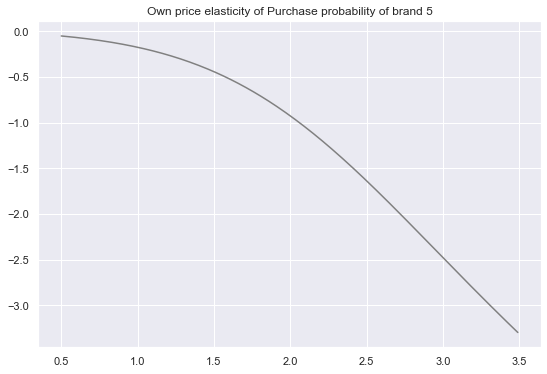

In [73]:
plt.figure(figsize=(9,6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel = 'Price 5'
plt.ylabel = 'Elasticity'
plt.title('Own price elasticity of Purchase probability of brand 5')
plt.show()

# Cross Price Elasticity Brand 5, Cross Brand 4

In [74]:
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))

In [75]:
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [76]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [77]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [78]:
pr_brand4 = predict_brand5_cross_brand4[:][:,3]

In [79]:
beta5

-1.09

In [80]:
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand4

In [82]:
df_price_elasticities['Brand5_cross_Brand4'] = brand5_cross_brand4_price_elasticity

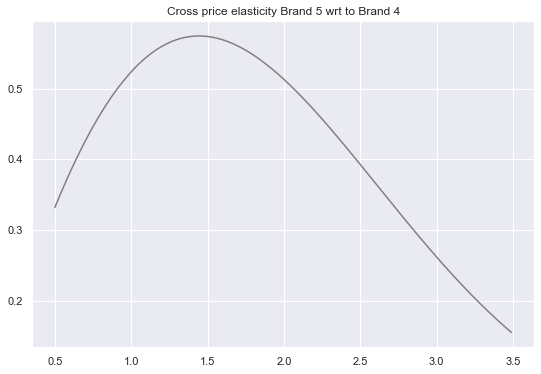

In [83]:
plt.figure(figsize=(9,6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel = 'Price 5'
plt.ylabel = 'Elasticity'
plt.title('Cross price elasticity Brand 5 wrt to Brand 4')
plt.show()

## Own and Cross-Price Elasticity by Segment

### Well-off

In [85]:
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

brand_choice_s1.head(5)

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,1,0,1,0,0
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,1,0,1,0,0
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,1,0,1,0,0
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,1,0,1,0,0
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,1,0,1,0,0


In [86]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


In [87]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities['Brand 5 S1'] = own_price_elasticity_brand_5_s1

### Cross Brand Price Elasticity

In [90]:
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities['Brand_5_Cross_Brand_4_S1'] = brand5_cross_brand4_price_elasticity_s1

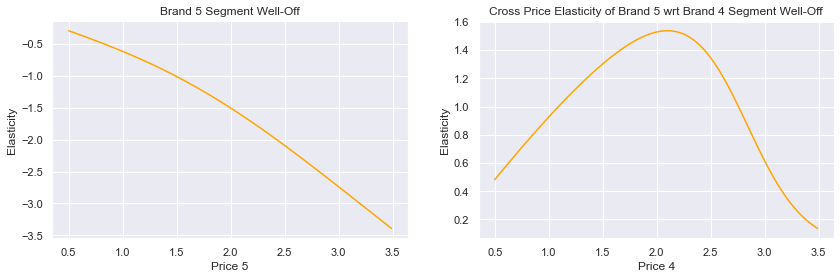

In [91]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s1, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

## Career Focused

In [92]:
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [93]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

In [94]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities['Brand 5 S2'] = own_price_elasticity_brand_5_s2

In [95]:
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities['Brand_5_Cross_Brand_4_S2'] = brand5_cross_brand4_price_elasticity_s2

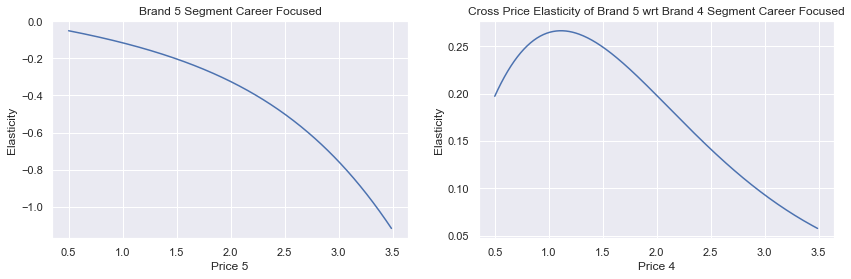

In [96]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s2, color = 'b')
axs[0].set_title('Brand 5 Segment Career Focused')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, color = 'b')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Career Focused')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

## Fewer - opp

In [97]:
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

In [98]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

In [99]:
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

In [101]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities.head(5)

,Price_Point,Mean_PE,PE_segment_1,PE_segment_2,PE_segment_4,Elascticity_Promotion,Elasticity_Promotion_0,Brand_5,Brand5_cross_Brand4,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096494,-0.167862,-0.117467,-0.221137,-0.125737,-0.195651,-0.049055,0.332011,-0.297335,0.482421,-0.050918,0.197364,-0.000825,0.152366
1,0.51,-0.100566,-0.172780,-0.121526,-0.227938,-0.129853,-0.201773,-0.050616,0.337287,-0.303382,0.491726,-0.052061,0.199852,-0.000875,0.154416
2,0.52,-0.104765,-0.177769,-0.125672,-0.234847,-0.134048,-0.207997,-0.052207,0.342507,-0.309438,0.501016,-0.053209,0.202288,-0.000928,0.156429
3,0.53,-0.109095,-0.182828,-0.129907,-0.241865,-0.138323,-0.214324,-0.053827,0.347668,-0.315505,0.510290,-0.054363,0.204671,-0.000983,0.158406
4,0.54,-0.113558,-0.187958,-0.134232,-0.248992,-0.142679,-0.220756,-0.055477,0.352773,-0.321584,0.519548,-0.055522,0.207002,-0.001042,0.160346


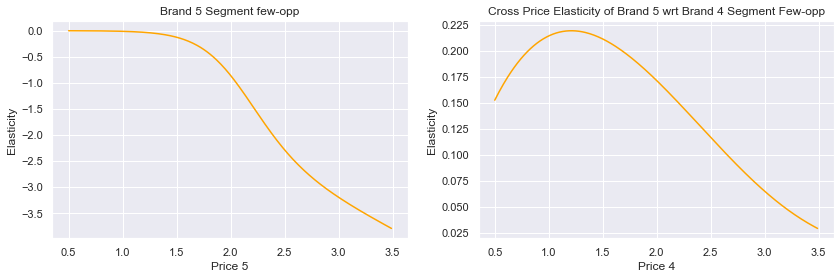

In [102]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment few-opp')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Few-opp')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

## Standard

In [103]:
brand_choice_s4 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s4 = brand_choice_s4[brand_choice_s4['Segment'] == 0]

In [104]:
Y = brand_choice_s4['Brand']
brand_choice_s4 = pd.get_dummies(brand_choice_s4, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s4[features]
model_brand_choice_s4 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s4.fit(X, Y)

# Coefficients table for segment 4
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s4.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

In [105]:
df_own_brand_5_s4 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s4['Price_1'] = brand_choice_s4['Price_1'].mean()
df_own_brand_5_s4['Price_2'] = brand_choice_s4['Price_2'].mean()
df_own_brand_5_s4['Price_3'] = brand_choice_s4['Price_3'].mean()
df_own_brand_5_s4['Price_4'] = brand_choice_s4['Price_4'].mean()
df_own_brand_5_s4['Price_5'] = price_range

predict_own_brand_5_s4 = model_brand_choice_s4.predict_proba(df_own_brand_5_s4)
pr_own_brand_5_s4= predict_own_brand_5_s4[: ][: , 4]

own_price_elasticity_brand_5_s4 =  beta5 * price_range * (1 - pr_own_brand_5_s4)
df_price_elasticities['Brand 5 S4'] = own_price_elasticity_brand_5_s4

In [106]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s4['Price_1'] = brand_choice_s4['Price_1'].mean()
df_brand5_cross_brand4_s4['Price_2'] = brand_choice_s4['Price_2'].mean()
df_brand5_cross_brand4_s4['Price_3'] = brand_choice_s4['Price_3'].mean()
df_brand5_cross_brand4_s4['Price_4'] = price_range
df_brand5_cross_brand4_s4['Price_5'] = brand_choice_s4['Price_5'].mean()

predict_brand5_cross_brand4_s4 = model_brand_choice_s4.predict_proba(df_brand5_cross_brand4_s4)
pr_cross_brand_5_s4 = predict_brand5_cross_brand4_s4[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s4 = -beta5 * price_range * pr_cross_brand_5_s4
df_price_elasticities['Brand_5_Cross_Brand_4_S4'] = brand5_cross_brand4_price_elasticity_s4

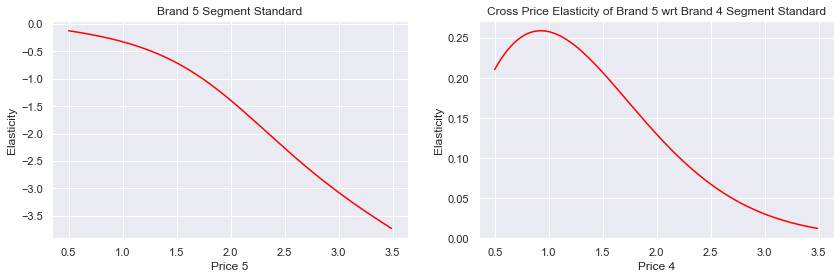

In [107]:
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s4, color = 'red')
axs[0].set_title('Brand 5 Segment Standard')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s4, color = 'red')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Standard')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

Text(0.5, 0, 'Price 4')

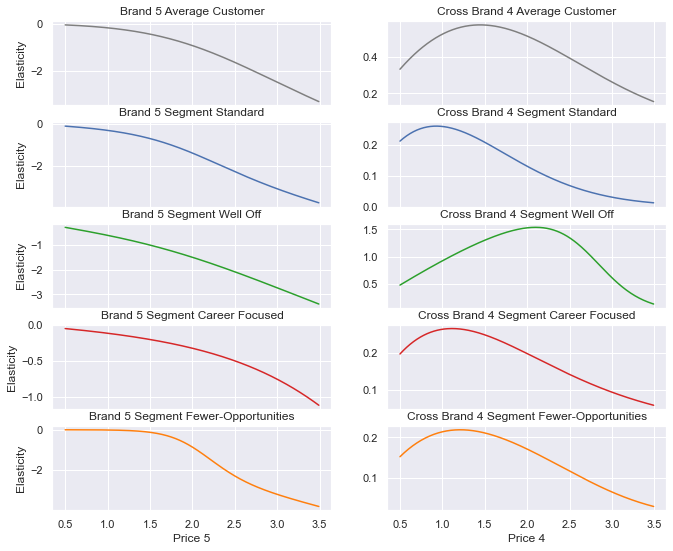

In [108]:
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s4)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s4)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Well Off')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Well Off')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Career Focused')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Career Focused')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')
ax5[1].set_xlabel('Price 4')